# Neural network based integrator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from dynamical_system import *
from time_integrator import *
from nn_integrator import *
%matplotlib inline

np.random.seed(2512517)

## Neural network integrators
Let $q(t)=(x(t),p(t))\in\mathbb{R}^{2d}$ be the state vector. Two methods are implemented to advance this state vector in time:

### Multistep neural network
The `MultistepNNIntegrator` class is used to implement a neural network based integrator with a $S$-step method. This is integrating a given $d$-dimensional system $\frac{dq(t)}{dt}=\mathcal{N}(q(t))$. The underlying neural model implements the mapping

$$
q^{(t-(S-1)\Delta t)},\dots,q^{(t-\Delta t)},q^{(t)} \mapsto q^{(t+\Delta t)}
$$

Internally this is realised by mapping the $B\times S \times d$ tensor $X$ to the $B\times d$ tensor $y$, where $B$ is the minibatch-size. This mapping is of the following form:

$$
y_{b,j} = X_{b,S-1,j} + \Delta t \cdot \Phi_{bj}(X)
$$

where $\Phi$ is a dense neural network. Note that for each batch index $b$, $X_{b,S-1,\cdot}$ is simply the vector $q^{(t)}_b$, i.e. we assume that $q^{(t+\Delta t)}$ is $q^{(t)}$ plus $\Delta t$ times some correction. The neural network $\Phi$ can take different form:
* it can simply be a set of dense layers or
* it can be a two-layer LSTM network, followed by a dense layer as in [https://arxiv.org/abs/2004.06493](https://arxiv.org/abs/2004.06493)

### Hamiltonian neural network integrator
Alternatively, the `HamiltonianNNIntegrator` implements a single-step Stoermer-Verlet method for a Hamiltonian system, following the ideas in [https://arxiv.org/abs/1906.01563](https://arxiv.org/abs/1906.01563). In this case the update $q^{(t)}\mapsto q^{(t+\Delta t)}$ takes the form:

$$
\begin{aligned}
p^{(t+\Delta t/2)} &= p^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t)}\right)\\[1ex]
x^{(t+\Delta t)} &= x^{(t)} + \Delta t \frac{\partial T}{\partial p}\left(p^{(t+\Delta t/2)}\right)\\[1ex]
p^{(t+\Delta t)} &= p^{(t)} - \frac{\Delta t}{2} \frac{\partial V}{\partial x}\left(x^{(t+\Delta t)}\right)
\end{aligned}
$$

Assuming that the Hamiltonian $H(x,p) = T(p) + V(x)$ is separable, the kinetic energy $T(p)$ and potential energy $V(x)$ are represented by neural networks.

### Set up system
Set system parameters, construct dynamical system and integrator.

The timestep size of the Neural network integrator is set to $\Delta t=40\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

In [9]:
#system_label = 'harmonic oscillator'
system_label = 'coupled pendulums'
if system_label == 'harmonic oscillator':
    # mass of particle
    mass = 1.2
    # spring constant
    k_spring = 0.9
    dynamical_system = HarmonicOscillator(mass,k_spring)
elif system_label == 'coupled pendulums':
    # mass of particle
    mass = 1.0
    # length of rods
    L_rod = 1.0
    # distance of anchor points
    d_anchor = 1.0
    # spring constant
    k_spring = 1.0
    dynamical_system = CoupledPendulums(mass,L_rod,d_anchor,k_spring) 
else:
    print(f'ERROR: unknown dynamical system: \"{system_label}\"')

# timestep for training integrator
dt_train = 0.005
# timestep for neural network integrator
dt = 0.2
# number of steps for multistep neural network integrator
nsteps = 6
# re-train model?
re_train = False

# use Hamiltonian model?
use_hamiltonian = True
# use LSTM network for multistep integrator?
use_LSTM = False
# use exact integrator for training?
use_exact_integrator=False

# Integrator used to generate data
if use_exact_integrator:
    train_integrator = ExactIntegrator(dynamical_system,dt_train)
else:
    train_integrator = VerletIntegrator(dynamical_system,dt_train)

BATCH_SIZE=64
EPOCHS=10
STEPS_PER_EPOCH=1000

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=EPOCHS*STEPS_PER_EPOCH,
    alpha=1.E-3)

if use_hamiltonian:
    if re_train:
        dirname = 'trained_models/coupled_pendulums/hamiltonian_40x/'
        V_pot_layers, V_pot_layer_weights = HamiltonianVerletNNIntegrator.load_layers(dirname+'/V_pot_layers.json')
        T_kin_layers, T_kin_layer_weights = HamiltonianVerletNNIntegrator.load_layers(dirname+'/T_kin_layers.json')
    else:
        V_pot_layers = [keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]
        T_kin_layers = [keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]
        V_pot_layer_weights = None
        T_kin_layer_weights = None
    nn_integrator = HamiltonianVerletNNIntegrator(dynamical_system,dt,V_pot_layers,T_kin_layers,
                                                  V_pot_layer_weights,T_kin_layer_weights,
                                                  learning_rate)

else:
    if use_LSTM: 
        # Use two layers of LSTMs followed by a dense layer
        dense_layers = [keras.layers.LSTM(64,return_sequences=True),
                        keras.layers.LSTM(64),
                        keras.layers.Dense(32,activation='tanh')]
    else:
        # Just use several dense layers
        dense_layers = [keras.layers.Flatten(),
                        keras.layers.Dense(32,activation='tanh'),
                        keras.layers.Dense(64,activation='tanh'),
                        keras.layers.Dense(32,activation='tanh')]


    nn_integrator = MultistepNNIntegrator(dynamical_system,dt,nsteps,
                                          learning_rate,
                                          dense_layers)

# visualise the neural network model
nn_integrator.model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 verlet_model_2 (VerletModel  (None, 4)                12928     
 )                                                               
                                                                 
Total params: 12,928
Trainable params: 12,928
Non-trainable params: 0
_________________________________________________________________


## Data generator
The following data generator class can be used to construct training data samples of the form $(X_j,y_j)$ where

$$
X_j = q_j^{(0)},q_j^{(\Delta t)},\dots,q_j^{((S-1)\Delta t)},\qquad\qquad y_j = q_j^{(S\Delta t)}.
$$

Here $q_j^{(0)}$ is a randomly chosen initial condition and the states $q_j^{(\Delta t)},q_j^{(2\Delta t)},\dots,q_j^{((S-1)\Delta t)}, q_j^{(S\Delta t)}$ are generated with a training generator (=Verlet) that is run with a smaller timestep.

In [10]:
class DataGenerator(object):
    def __init__(self,nn_integrator,train_integrator):        
        self.nn_integrator = nn_integrator
        self.train_integrator = train_integrator
        self.dynamical_system = self.nn_integrator.dynamical_system
        self.dataset = tf.data.Dataset.from_generator(self._generator,                                                      
                                                      output_signature=(
                                                          tf.TensorSpec(shape=(self.nn_integrator.nsteps,
                                                                               2*self.dynamical_system.dim), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(2*self.dynamical_system.dim), dtype=tf.float32)
                                                      ))
    
    def _generator(self):
        state = np.zeros((self.nn_integrator.nsteps+1,2*self.dynamical_system.dim))
        while True:
            self.dynamical_system.set_random_state(state[0,:self.dynamical_system.dim],
                                                   state[0,self.dynamical_system.dim:])
            self.train_integrator.set_state(state[0,:self.dynamical_system.dim],
                                            state[0,self.dynamical_system.dim:])
            for k in range(self.nn_integrator.nsteps):
                self.train_integrator.integrate(int(self.nn_integrator.dt/self.train_integrator.dt))
                state[k+1,:self.dynamical_system.dim] = self.train_integrator.q[:]
                state[k+1,self.dynamical_system.dim:] = self.train_integrator.p[:]
            X = state[:-1,:]
            y = state[-1,:]
            yield (X,y)
    
data_generator = DataGenerator(nn_integrator,train_integrator)

## Train neural network based integrator

Note that training history can be visualised with tensorboard:

```
tensorboard --logdir=./tb_logs
```

In [ ]:
log_dir = './tb_logs/'
train_batches = data_generator.dataset.batch(BATCH_SIZE)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result = nn_integrator.model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)

## Visualise loss history

Plot the loss history for both the vanilla dense network and the LSTM network.

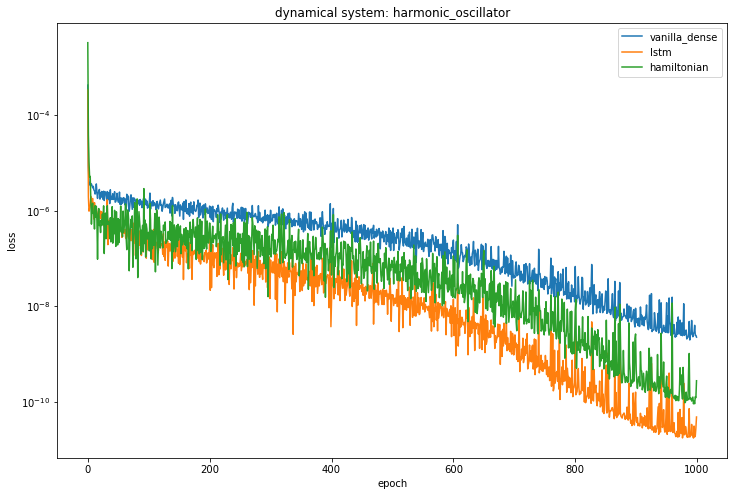

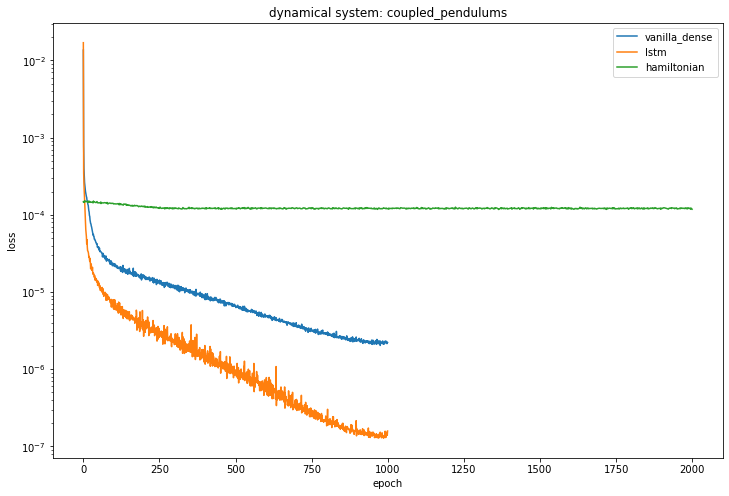

In [5]:
import pandas as pd
modelnames = ('vanilla_dense', 'lstm','hamiltonian')
systemnames = ('harmonic_oscillator','coupled_pendulums')
for systemname in systemnames:
    plt.figure(figsize=(12, 8))
    for modelname in modelnames:
        steps = ('' if modelname=='hamiltonian' else '_6steps')
        filename = 'loss_history_'+systemname+'_'+modelname+'_40x'+steps+'.csv'
        data = pd.read_csv(filename)
        X = data['Step'].to_numpy()
        Y = data['Value'].to_numpy()
        plt.title('dynamical system: '+systemname)
        plt.plot(X,Y,label=modelname)
    ax = plt.gca()
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_yscale('log')
    plt.legend(loc='upper right')
    plt.show()

## Plot trajectories and energy drift

Visualise the position $x(t)$ and the position error $x(t)-x_{\text{exact}}(t)$ for the following setups:

1. Verlet integrator with timestep $\Delta t_{\text{train}}$
2. Coarse Verlet integrator with timestep $\Delta t = 40\Delta t_{\text{train}}$
3. Vanilla dense network with timestep $\Delta t = 40\Delta t_{\text{train}}$
4. LSTM network with timestep $\Delta t = 40\Delta t_{\text{train}}$

For all four setups, also visualise the energy drift $E(t)-E(t=0)$.

Note that this will load the trained models from disk, so this will only work if you have these files (I didn't commit them to the repository since they are very large).

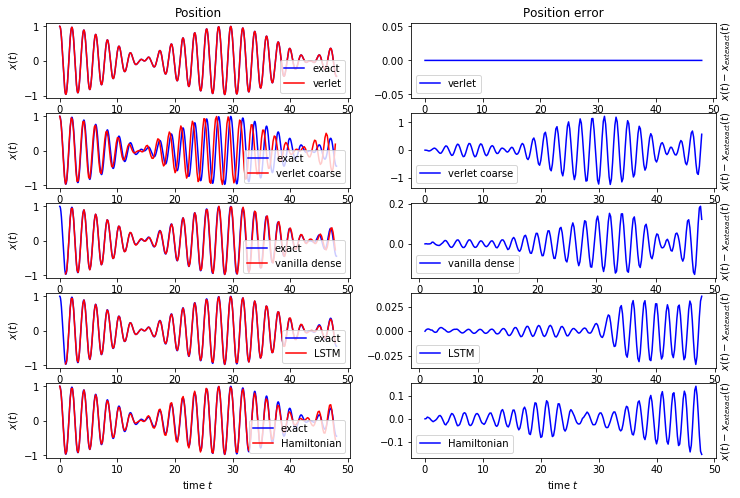

<Figure size 432x288 with 0 Axes>

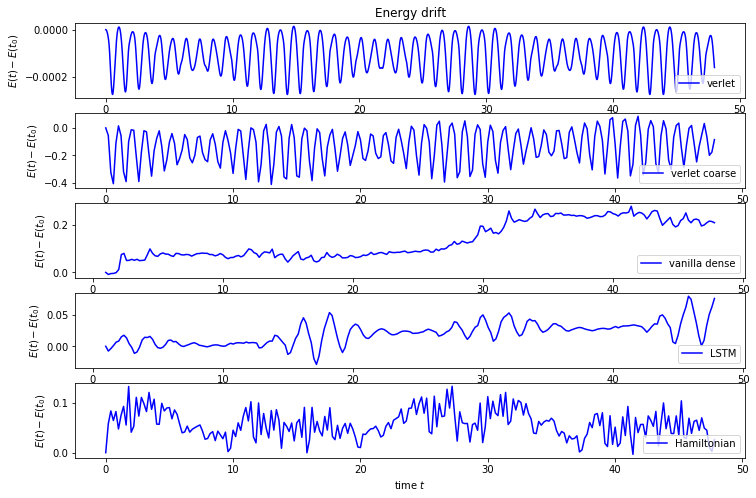

In [17]:
# Final time
T_final = 48

# Initial conditions
q0 = np.zeros(dynamical_system.dim)
p0 = np.zeros(dynamical_system.dim)
if system_label == 'coupled pendulums':
    q0[:] = (1, 0)
    p0[:] = (0, 0)
else:
    q0[:] = 1
    p0[:] = 1
verlet_integrator = VerletIntegrator(dynamical_system,dt_train)
verlet_integrator.set_state(q0,p0)
if system_label == 'coupled pendulums':
    exact_integrator = VerletIntegrator(dynamical_system,dt_train)
else:
    exact_integrator = ExactIntegrator(dynamical_system,dt_train)
exact_integrator.set_state(q0,p0)

# ==== Verlet- and exact integrator ====
t0 = 0.0
t = {} # times
q = {} # positions
E = {} # energies
dq = {} # position errors
t['exact'] = []
t['verlet'] = []
q['exact'] = []
q['verlet'] = []
E['exact'] = []
E['verlet'] = []
dq['verlet'] = []
while t0<T_final:
    t['exact'].append(t0)
    t['verlet'].append(t0)
    E['exact'].append(exact_integrator.energy())
    q['exact'].append(exact_integrator.q[0])
    E['verlet'].append(verlet_integrator.energy())
    q['verlet'].append(verlet_integrator.q[0])
    dq['verlet'].append(verlet_integrator.q[0]-exact_integrator.q[0])
    verlet_integrator.integrate(1)
    exact_integrator.integrate(1)
    t0 += dt_train

# Verlet with large timestep

t['verlet coarse'] = []
q['verlet coarse'] = []
E['verlet coarse'] = []
dq['verlet coarse'] = []
coarse_verlet_integrator = VerletIntegrator(dynamical_system,dt)
coarse_verlet_integrator.set_state(q0,p0)
exact_integrator.set_state(q0,p0)
t0 = 0.0
nsteps = int(dt/dt_train)
while t0<T_final:
    t['verlet coarse'].append(t0)
    E['verlet coarse'].append(coarse_verlet_integrator.energy())
    q['verlet coarse'].append(coarse_verlet_integrator.q[0])
    dq['verlet coarse'].append(coarse_verlet_integrator.q[0]-exact_integrator.q[0])
    coarse_verlet_integrator.integrate(1)
    exact_integrator.integrate(nsteps)
    t0 += dt

# ==== Neural network integrators ====

if system_label == 'coupled pendulums':
    directory = 'trained_models/coupled_pendulums/'    
else:
    directory = 'trained_models/harmonic_oscillator/'
models = {'vanilla dense':keras.models.load_model(directory+'vanilla_dense_40x_6steps'),
          'LSTM':keras.models.load_model(directory+'lstm_40x_6steps'),
          'Hamiltonian':HamiltonianVerletNNIntegrator.load_model(directory+'hamiltonian_40x')}
for label,model in models.items():
    nn_integrator = NNIntegrator.from_model(dynamical_system,dt,model)
    # Initialise with exact integrator
    q_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    p_initial = np.zeros((nn_integrator.nsteps,dynamical_system.dim))
    exact_integrator.set_state(q0,p0)
    for k in range(nn_integrator.nsteps):    
        q_initial[k,:] = exact_integrator.q[:]
        p_initial[k,:] = exact_integrator.p[:]
        exact_integrator.integrate(int(dt/dt_train))
        nsteps += 1
    nn_integrator.set_state(q_initial,p_initial)
    t0 = (nn_integrator.nsteps-1)*nn_integrator.dt
    
    # Timestepping loop
    t[label] = []
    q[label] = []
    E[label] = []
    dq[label] = []
    nsteps = (nn_integrator.nsteps-1)*int(dt/dt_train)
    while t0<T_final:
        t[label].append(t0)
        q_nn = nn_integrator.q[0]
        exact_integrator.set_state(q0,p0)
        exact_integrator.integrate(nsteps)
        q_exact = exact_integrator.q[0]
        q[label].append(q_nn)
        dq[label].append(q_nn-q_exact)
        E[label].append(nn_integrator.energy())
        nn_integrator.integrate(1)
        t0 += dt
        nsteps += int(dt/dt_train)

# Plot position as a function of time
fig, axs = plt.subplots(5,2,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j][0] 
    ax.plot(t['exact'],q['exact'],label='exact',color='blue')
    ax.plot(t[label],q[label],label=label,color='red')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)$')
    if j==0:
        ax.set_title('Position')
    ax = axs[j][1] 
    ax.plot(t[label],np.asarray(dq[label]),label=label,color='blue')
    ax.legend(loc='lower left')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$x(t)-x_{\text{exact}}(t)$')
    ax.yaxis.set_label_position("right")
    if j==0:
        ax.set_title('Position error')
plt.show()

plt.clf()
fig, axs = plt.subplots(5,1,figsize=(12, 8))
for j,label in enumerate(('verlet','verlet coarse','vanilla dense','LSTM','Hamiltonian')):
    ax = axs[j]
    ax.plot(t[label],np.asarray(E[label])-E[label][0],label=label,color='blue')
    ax.legend(loc='lower right')
    ax.set_xlabel('time $t$')
    ax.set_ylabel('$E(t)-E(t_0)$')
    if j==0:
        ax.set_title('Energy drift')
plt.show()

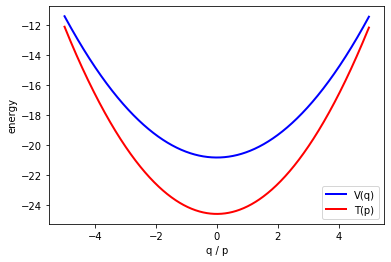

In [12]:
# Plot potential and kinetic energy (for debugging, can only be used with Hamiltonian network)
model = HamiltonianVerletNNIntegrator.load_model('trained_models/harmonic_oscillator/hamiltonian_40x')
    
X = tf.expand_dims(tf.constant(np.arange(-5.0,+5.0,0.01)),axis=1)

V_pot = model.layers[-1].V_pot(X).numpy().flatten()
T_kin = model.layers[-1].T_kin(X).numpy().flatten()
plt.plot(X,V_pot,linewidth=2,color='blue',label='V(q)')
plt.plot(X,T_kin,linewidth=2,color='red',label='T(p)')
ax = plt.gca()
ax.set_xlabel('q / p')
ax.set_ylabel('energy')
ax.legend(loc='lower right')
plt.show()